In [89]:
# Don't runt this. It takes 20-ish seconds. The best param is:
# 'bandwidth': 5.214008287999687

0/0

from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

bandwidths = 10 ** np.linspace(-1, 1, 100)
grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                    {'bandwidth': bandwidths})

grid.fit(df[['Budget']])

grid.best_params_

In [2]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

In [3]:
df = pd.read_csv(r'C:\Users\matte\OneDrive\Desktop\GitHub\jup_lab\movies_2004_2023_cleaned.csv')

## Distribution of the budget

In [4]:
from sklearn.neighbors import KernelDensity

# Create a dataframe (with the same name of what we're predicting)
# that will be our x. I.e. in the graph below there are 30000 points
# from df['Budget'].min() to 200

x_d = pd.DataFrame(data={'Budget':np.linspace(df['Budget'].min(), 200, 30000)})

# instantiate and fit the KDE model
kde = KernelDensity(bandwidth=5.214, kernel='gaussian')
kde.fit(df[['Budget']])

# get the log of the probability density
logprob = kde.score_samples(x_d)

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

In [5]:
n_movies = df['Budget'].count()
n_movies

2842

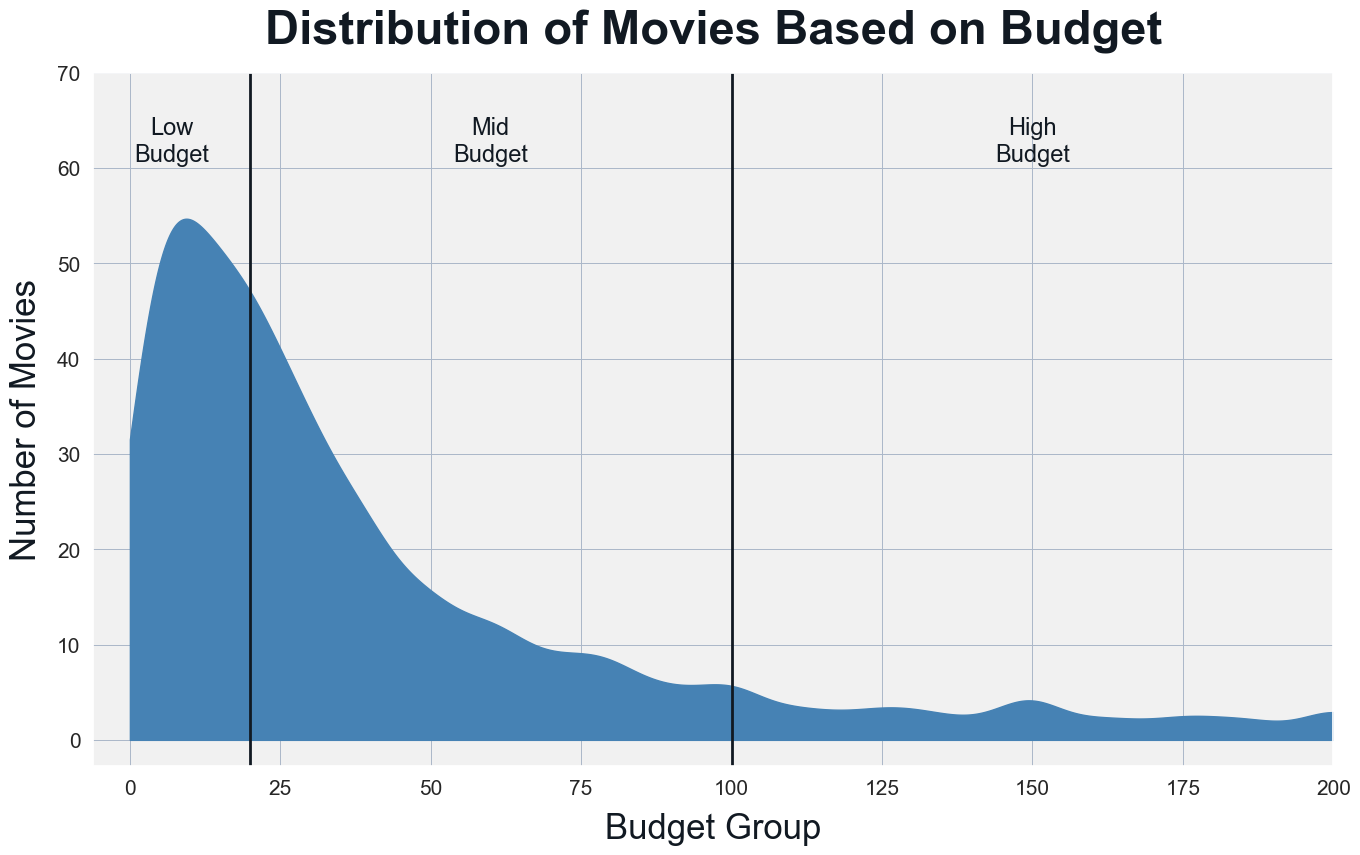

In [72]:
fig, ax = plt.subplots(figsize=(16,9))

plt.axvline(x=20, color='#111922',linewidth=2)
plt.axvline(x=100, color='#111922',linewidth=2)

ax.annotate('Low\nBudget', xy=(7, 0.022),
            ha='center', va='center', fontsize=17, color='#111922')
ax.annotate('Mid\nBudget', xy=(60, 0.022),
            ha='center', va='center', fontsize=17, color='#111922')
ax.annotate('High\nBudget', xy=(150, 0.022),
            ha='center', va='center', fontsize=17, color='#111922')

ax.fill_between(x_d['Budget'], np.exp(logprob), alpha=1, color='steelblue')

ax.set_yticks((0, 0.0035, 0.007, 0.0105 ,0.014, 0.0175, 0.021, 0.0245))
ax.set_yticklabels((0, 10, 20, 30, 40, 50, 60, 70), fontsize=15)
ax.set_xticks((0,25,50,75,100,125,150,175,200))
ax.set_xticklabels((0,25,50,75,100,125,150,175,200),fontsize=15)

ax.set_ylabel('Number of Movies', fontsize=25, labelpad=10, color='#111922')
ax.set_xlabel('Budget Group', fontsize=25, labelpad=10, color='#111922')
ax.set_title('Distribution of Movies Based on Budget',
             fontsize=34, pad=21, fontweight='bold', color='#111922')

ax.set_facecolor("#F1F1F1")
plt.grid(color = '#AAB7C8', linestyle = '-', linewidth = 0.7)
ax.set_xlim([-6, 200]);

### Low budget Preparation

In [7]:
genres = ['action','adventure','animated','biographical','black','buddy','comedy',
 'comedy-drama','crime','drama','epic','fantasy','fiction','historical','horror','musical',
 'psychological','romantic','science','sports','superhero','supernatural','thriller','war']

In [8]:
budget_group = df['Budget group']

<Axes: >

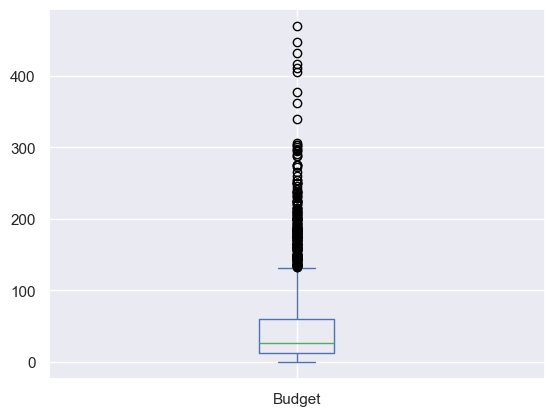

In [9]:
df['Budget'].plot.box()

I'll delete the movies with a too high profit perc. Their success is amazing and hard to replicate.

In [10]:
def get_limits(df):
    print('llimit', str(df.quantile(0.25) - 1.5*(df.quantile(0.75) - df.quantile(0.25))))
    print('ulimit', str(df.quantile(0.75) + 1.5*(df.quantile(0.75) - df.quantile(0.25))))
    print('Extreme llimit', str(df.quantile(0.25) - 3*(df.quantile(0.75) - df.quantile(0.25))))
    print('Extreme ulimit', str(df.quantile(0.75) + 3*(df.quantile(0.75) - df.quantile(0.25))))

#### Handling the outliers of Profit perc in low df

In [11]:
get_limits(df.loc[budget_group == 'low', 'Profit perc'])

llimit -639.947915
ulimit 937.468749
Extreme llimit -1231.479164
Extreme ulimit 1528.999998


In [12]:
(df.loc[budget_group == 'low', 'Profit perc'] > 938).sum()

103

In [13]:
low_df = df.loc[(budget_group == 'low') & (df['Profit perc'] < 938)]
low_df.shape

(1104, 33)

In [14]:
def profit_genre(df, genres, col):
    for i in genres:
        if df[i] == 1:
            df[i] = df[col]
    return df

#### I grab the genres that have at least 15 occurrences

In [15]:
low_df[genres].sum(axis=0)

action            72.0
adventure         17.0
animated          12.0
biographical      62.0
black             41.0
buddy             13.0
comedy           256.0
comedy-drama     148.0
crime             63.0
drama            320.0
epic               9.0
fantasy           21.0
fiction           41.0
historical        15.0
horror           139.0
musical           19.0
psychological     53.0
romantic         134.0
science           43.0
sports            24.0
superhero          7.0
supernatural      52.0
thriller         132.0
war               18.0
dtype: float64

# Start analysis

### Low budget

In [16]:
low_genres = low_df[genres].sum(axis=0).loc[low_df[genres].sum(axis=0) > 15].index.tolist()
print(low_genres)

['action', 'adventure', 'biographical', 'black', 'comedy', 'comedy-drama', 'crime', 'drama', 'fantasy', 'fiction', 'horror', 'musical', 'psychological', 'romantic', 'science', 'sports', 'supernatural', 'thriller', 'war']


In [17]:
low_df_profit_perc = low_df[low_genres+ ['Profit perc']].apply(profit_genre, genres=low_genres,
                                     col='Profit perc', axis=1)

low_df_profit_perc[low_df_profit_perc == 0] = np.nan

In [18]:
low_df_profit_perc.drop(columns='Profit perc').median(axis=0).sort_values().to_frame().reset_index()

,index,0
0,sports,-38.635416
1,biographical,6.340909
2,fiction,10.000000
3,science,10.000000
4,drama,14.807692
5,action,15.916666
6,musical,26.000000
7,thriller,28.250000
8,black,32.500000
9,crime,37.692307


#### ANOVA Test

In [19]:
from scipy.stats import f_oneway

data_for_anova = [low_df_profit_perc[x].dropna() for x in low_genres]

f_oneway(*data_for_anova)

F_onewayResult(statistic=4.592635769874004, pvalue=5.643487603027173e-10)

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


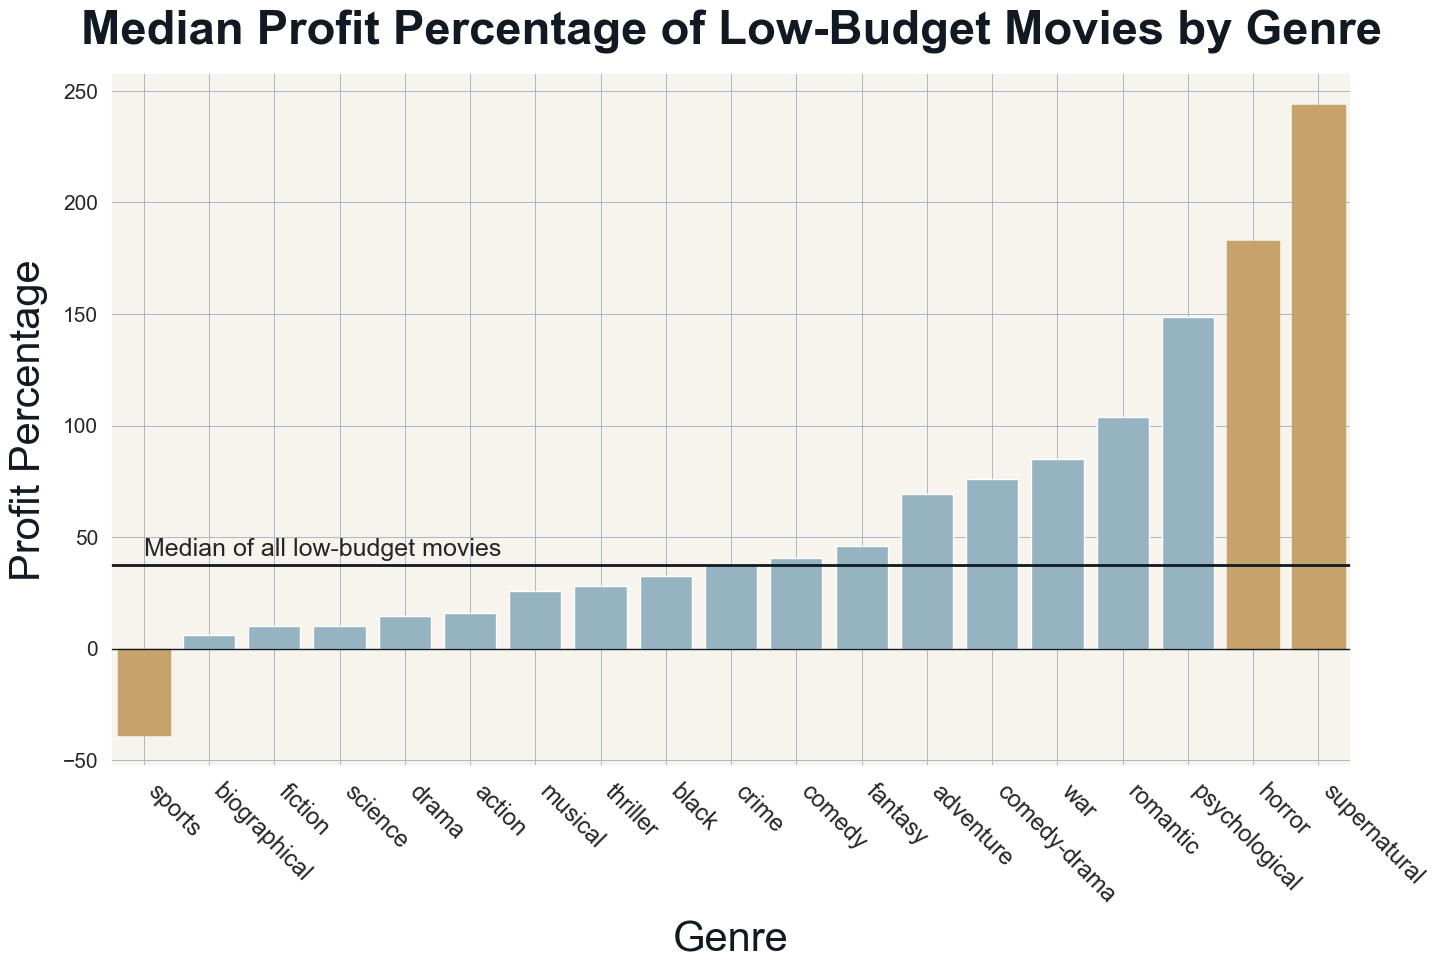

In [20]:
fig, ax = plt.subplots(figsize=(16,9))

data2 = low_df_profit_perc.drop(columns='Profit perc').median(axis=0).sort_values().to_frame().reset_index()

ax = sns.barplot(data=data2, x='index', y=0, color='steelblue', alpha=1)

ax.get_children()[0].set_color('#C6A36B')
ax.get_children()[17].set_color('#C6A36B') 
ax.get_children()[18].set_color('#C6A36B') 

plt.axhline(y=data2[0].median(), color='#111922',linewidth=2)
ax.annotate('Median of all low-budget movies', xy=(0, data2[0].median() + 7),
            ha='left', va='center', fontsize=18)

plt.yticks(fontsize=15)
plt.xticks(rotation=-45, fontsize=17, ha='left')

ax.set_ylabel('Profit Percentage', fontsize=30, labelpad=10, color='#111922')
ax.set_xlabel('Genre', fontsize=30, labelpad=10, color='#111922')
ax.set_title('Median Profit Percentage of Low-Budget Movies by Genre',
             fontsize=34, pad=21, fontweight='bold', color='#111922')

plt.axhline(y=0, color='#111922',linewidth=1)

ax.set_facecolor("#F1F1F1")
plt.grid(color = '#AAB7C8', linestyle = '-', linewidth = 0.7)
plt.show()

As we can see some genres have a very different mean from the mean of the whole group. Yet, it's too early to speak. We have to make sure that this is not something produced by chance alone.

In [21]:
pd.set_option('display.float_format',  '{:.4f}'.format)

from scipy.stats import pearsonr

pearsonr_df_stat= []
pearsonr_df_pv= []
pearsonr_id = []

for genre in low_genres:
    values = pearsonr(low_df[genre], low_df['Profit perc'])
    pearsonr_df_stat.append(values[0])
    pearsonr_df_pv.append(values[1])
    pearsonr_id.append(genre)


pearsonr_df = pd.DataFrame(index=pearsonr_id, data={'Correlation coef.':pearsonr_df_stat,
            'P-value':pearsonr_df_pv}).sort_values('P-value')
pearsonr_df

,Correlation coef.,P-value
supernatural,0.1586,0.0000
horror,0.1564,0.0000
psychological,0.0767,0.0108
drama,-0.0702,0.0196
sports,-0.0664,0.0275
biographical,-0.0649,0.0312
action,-0.0513,0.0883
musical,-0.0432,0.1512
romantic,0.0428,0.1551
thriller,-0.0342,0.2563


The only genres we can trust are the ones with a P-value < 0.05

In [22]:
pearsonr_df[pearsonr_df['P-value'] < 0.05]

,Correlation coef.,P-value
supernatural,0.1586,0.0000
horror,0.1564,0.0000
psychological,0.0767,0.0108
drama,-0.0702,0.0196
sports,-0.0664,0.0275
biographical,-0.0649,0.0312


In [23]:
low_genres_trust = pearsonr_df[pearsonr_df['P-value'] < 0.05].index.tolist()

I take that a step further. I wanna be more confident that these genres do indeed influece that Profit %... and it's not by chance.

So I use bootstrapping and confidence intervals.

In [24]:
from scipy.stats import bootstrap

def get_conf_df(df,genres, my_func):
    conf_df_id = []
    conf_df_low = []
    conf_df_high = []

    for genre in genres:
        df_to_test = (df[genre].dropna(),)
        bootstrap_ci = bootstrap(df_to_test,
                                my_func,
                                n_resamples=1999,
                                confidence_level=0.95,
                                random_state=1)

        conf_df_id.append(genre)
        conf_df_high.append(bootstrap_ci.confidence_interval[1])
        conf_df_low.append(bootstrap_ci.confidence_interval[0])
    
    return conf_df_id, conf_df_low, conf_df_high

mean_conf = get_conf_df(low_df_profit_perc,['Profit perc'] +low_genres_trust, np.median)

conf_df = pd.DataFrame(index=mean_conf[0], data={'Low band':mean_conf[1],
            'High band':mean_conf[2]})
conf_df

,Low band,High band
Profit perc,30.0000,69.4444
supernatural,179.5000,385.2365
horror,118.8235,246.3848
psychological,54.2857,254.6562
drama,-1.3204,43.6667
sports,-55.0000,12.5660
biographical,-50.0000,50.6250


These are the genres that don't overlap at 95% conficende level. We can trust that these genres do actually influence the profit % of a low budget movie.

In [25]:
mask1 = conf_df.loc[:,'Low band'] >= conf_df.loc['Profit perc', 'High band']
mask2 = conf_df.loc[:,'High band'] <= conf_df.loc['Profit perc', 'Low band']

low_genres_trust = conf_df[(mask1 | mask2)].index.tolist()
conf_df[(mask1 | mask2)]


,Low band,High band
supernatural,179.5000,385.2365
horror,118.8235,246.3848
sports,-55.0000,12.5660


C:\Users\matte\AppData\Local\Temp\ipykernel_12832\3766340070.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(('All Genres','Supernatural', 'Horror', 'Sports'))


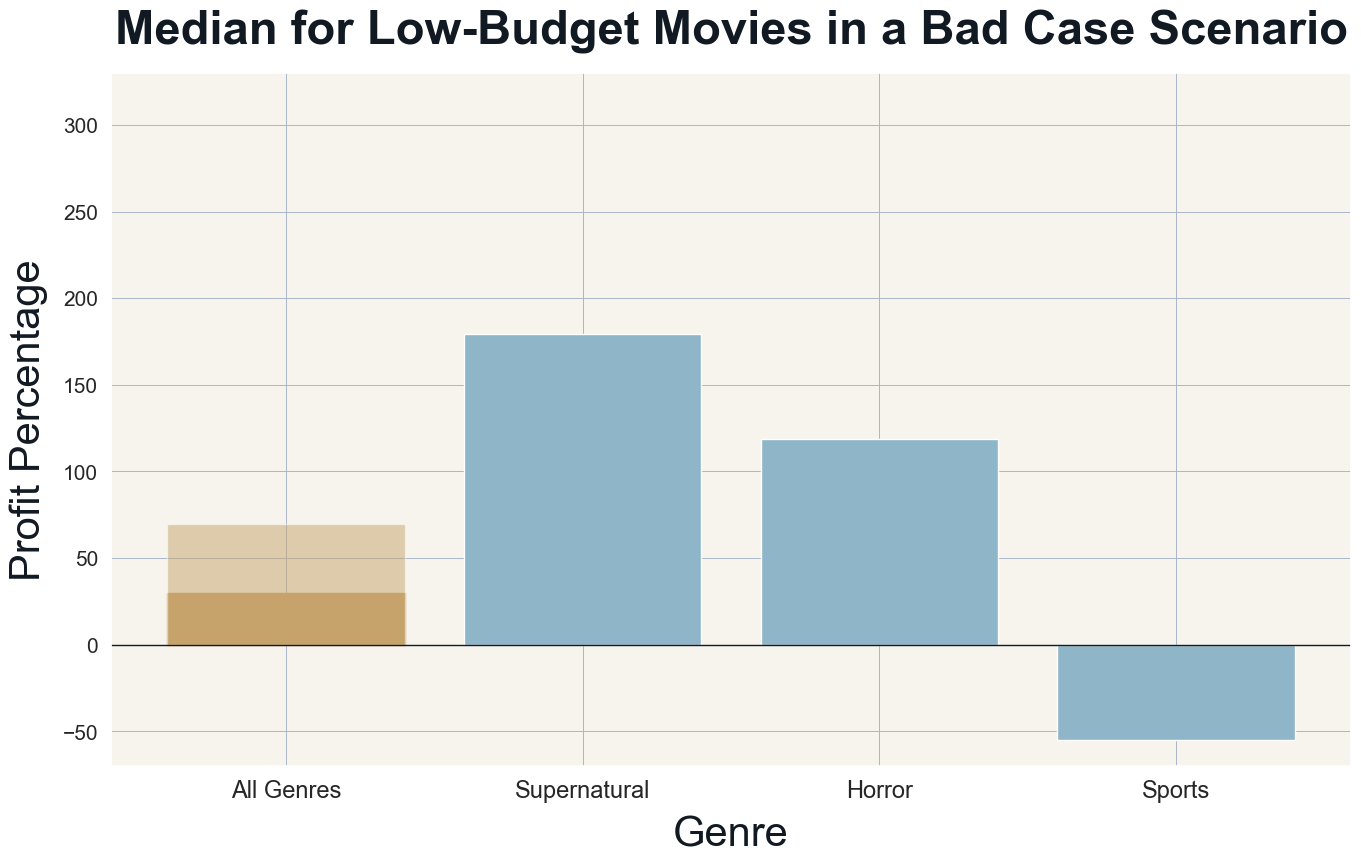

In [26]:
fig, ax = plt.subplots(figsize=(16,9))

data2 = conf_df.loc[['Profit perc'] + low_genres_trust]

ax.bar(data2.index, data2['Low band'], color='steelblue')

# The confidence interval on Profit %
ax.bar(x='Profit perc', height=conf_df.loc['Profit perc','High band'],
       bottom=0, alpha=0.5,color='#C6A36B')
ax.get_children()[0].set_color('#C6A36B')

ax.set_xticklabels(('All Genres','Supernatural', 'Horror', 'Sports'))

plt.yticks(fontsize=15)
plt.xticks(fontsize=17)

ax.set_ylabel('Profit Percentage', fontsize=30, labelpad=10, color='#111922')
ax.set_xlabel('Genre', fontsize=30, labelpad=10, color='#111922')
ax.set_title('Median for Low-Budget Movies in a Bad Case Scenario',
             fontsize=34, pad=21, fontweight='bold', color='#111922')

plt.axhline(y=0, color='#111922',linewidth=1)

ax.set_ylim([-70,330])
ax.set_facecolor("#F1F1F1")
plt.grid(color = '#AAB7C8', linestyle = '-', linewidth = 0.7)
plt.show()

C:\Users\matte\AppData\Local\Temp\ipykernel_12832\240403195.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(('All Genres','Supernatural', 'Horror', 'Sports'))


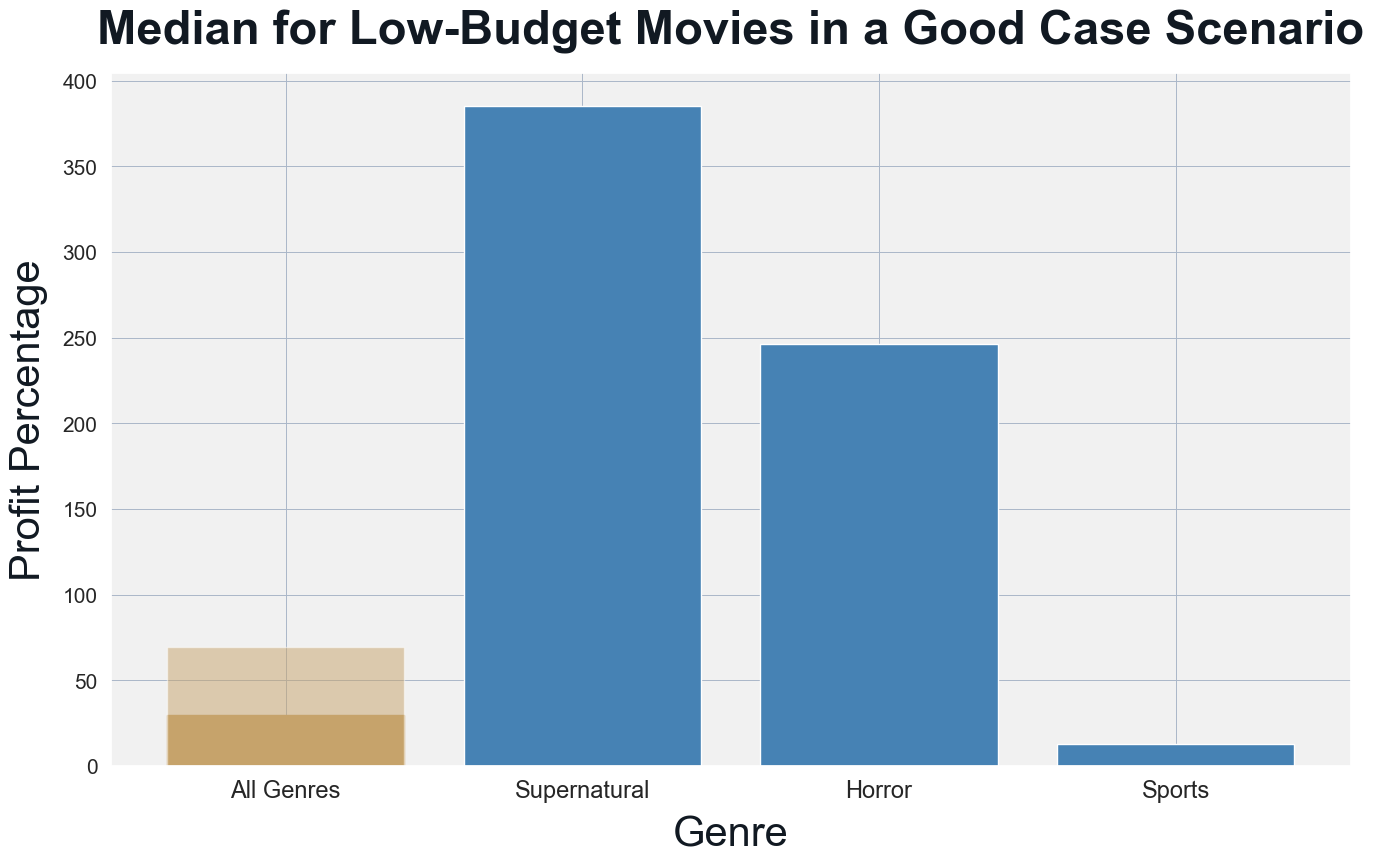

In [73]:
fig, ax = plt.subplots(figsize=(16,9))

data2 = conf_df.loc[['Profit perc'] + low_genres_trust]

# I change this so the bar of Profit % is equal to the one of the graph above
data2.loc['Profit perc','High band'] = data2.loc['Profit perc','Low band']

ax.bar(data2.index, data2['High band'], color='steelblue')

# The confidence interval on Profit %
ax.bar(x='Profit perc', height=conf_df.loc['Profit perc','High band'],
       bottom=0, alpha=0.5,color='#C6A36B')
ax.get_children()[0].set_color('#C6A36B')

ax.set_xticklabels(('All Genres','Supernatural', 'Horror', 'Sports'))
plt.yticks(fontsize=15)
plt.xticks(fontsize=17)

ax.set_ylabel('Profit Percentage', fontsize=30, labelpad=10, color='#111922')
ax.set_xlabel('Genre', fontsize=30, labelpad=10, color='#111922')
ax.set_title('Median for Low-Budget Movies in a Good Case Scenario',
             fontsize=34, pad=21, fontweight='bold', color='#111922')

ax.set_facecolor("#F1F1F1")
plt.grid(color = '#AAB7C8', linestyle = '-', linewidth = 0.7)
plt.show()

In [28]:
def my_q1(x):
    return np.quantile(a=x, q=0.25)

q1_conf = get_conf_df(low_df_profit_perc, low_genres_trust + ['Profit perc'], my_q1)

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


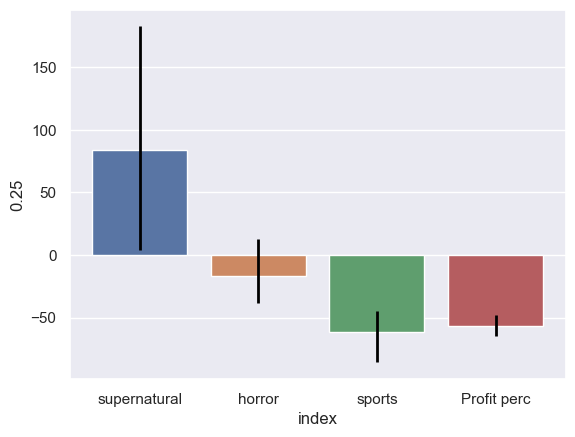

In [29]:
ax = sns.barplot(data=low_df_profit_perc[low_genres_trust + ['Profit perc']].quantile(0.25).to_frame().reset_index(),
            errorbar=None, x='index', y=0.25)

for n in range(len(q1_conf[0])):
    ax.vlines(x=n,
            ymin=q1_conf[1][n], ymax=q1_conf[2][n],
            linewidth=2, color='black');

#### I check to see if the confidence interval for the q3 overlap. I didn't do this for the q1 because there's a limit to how bad a movie can do.

In [30]:
#I have to use 0.751 and not 0.75 because 0.75 gives me a Runtime error.

def my_q3(x):
    return np.quantile(a=x, q=0.751)

q3_conf = get_conf_df(low_df_profit_perc, low_genres_trust + ['Profit perc'], my_q3)

In [31]:
q3_conf_df = pd.DataFrame(index=q3_conf[0], data={'Low band':q3_conf[1],
            'High band':q3_conf[2]})

mask1 = q3_conf_df.loc[:,'Low band'] > q3_conf_df.loc['Profit perc', 'High band']
mask2 = q3_conf_df.loc[:,'High band'] < q3_conf_df.loc['Profit perc', 'Low band']

q3_conf_df[(mask1 | mask2)]

,Low band,High band
supernatural,390.1562,678.0952
horror,327.7778,527.7372
sports,-28.3007,168.8235


c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


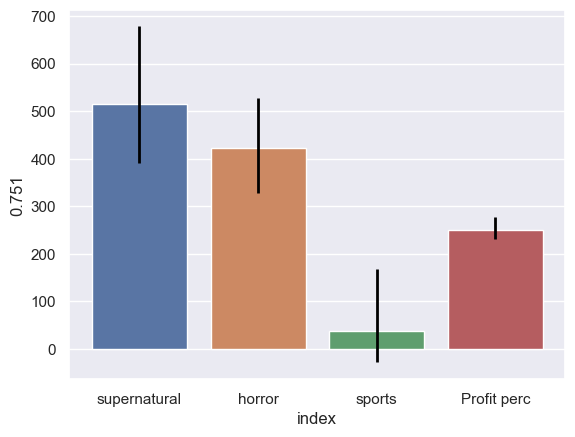

In [32]:
ax = sns.barplot(data=low_df_profit_perc[low_genres_trust + ['Profit perc']].quantile(0.751).to_frame().reset_index(),
            errorbar=None, x='index', y=0.751)

for n in range(len(q3_conf[0])):
    ax.vlines(x=n,
            ymin=q3_conf[1][n], ymax=q3_conf[2][n],
            linewidth=2, color='black');

## Mid Budget

#### Handling the outliers in Profit perc in mid budget

In [33]:
get_limits(df.loc[budget_group == 'mid', 'Profit perc'])

llimit -335.342105
ulimit 539.6052629999999
Extreme llimit -663.447368
Extreme ulimit 867.710526


In [34]:
(df.loc[budget_group == 'mid', 'Profit perc'] > 539).sum()

81

In [35]:
mid_df = df.loc[(budget_group == 'mid') & (df['Profit perc'] < 539)]
mid_df.shape

(1192, 33)

#### Grab the genres with at least 15 occurrences

In [36]:
mid_genres = mid_df[genres].sum(axis=0).loc[mid_df[genres].sum(axis=0) > 15].index.tolist()
print(mid_genres)

['action', 'adventure', 'animated', 'biographical', 'black', 'buddy', 'comedy', 'comedy-drama', 'crime', 'drama', 'epic', 'fantasy', 'fiction', 'historical', 'horror', 'musical', 'psychological', 'romantic', 'science', 'sports', 'superhero', 'supernatural', 'thriller', 'war']


In [37]:
mid_df_profit_perc = mid_df[mid_genres+ ['Profit perc']].apply(profit_genre, genres=mid_genres,
                                     col='Profit perc', axis=1)

mid_df_profit_perc[mid_df_profit_perc == 0] = np.nan

#### ANOVA Test

In [65]:
from scipy.stats import f_oneway

mid_data_for_anova = [mid_df_profit_perc[x].dropna() for x in mid_genres]

f_oneway(*mid_data_for_anova)

F_onewayResult(statistic=4.767020148885576, pvalue=7.028424180316639e-13)

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


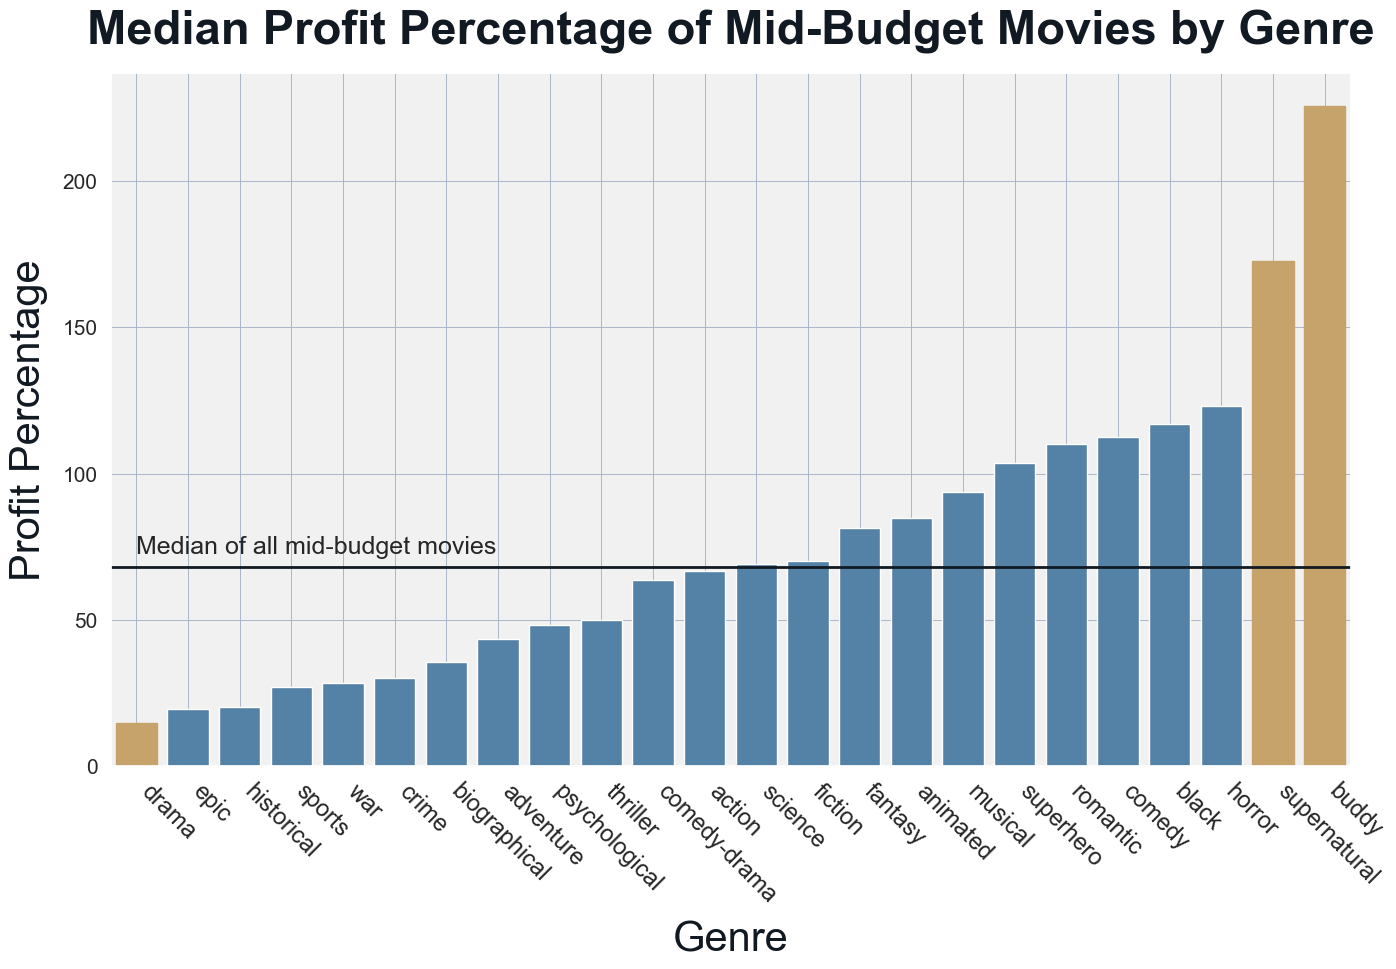

In [71]:
fig, ax = plt.subplots(figsize=(16,9))

data2 = mid_df_profit_perc.drop(columns='Profit perc').median(axis=0).sort_values().to_frame().reset_index()

ax = sns.barplot(data=data2, x='index', y=0, color='steelblue', alpha=1)

ax.get_children()[0].set_color('#C6A36B')
ax.get_children()[22].set_color('#C6A36B')
ax.get_children()[23].set_color('#C6A36B')

plt.axhline(y=data2[0].median(), color='#111922',linewidth=2)
ax.annotate('Median of all mid-budget movies', xy=(0, data2[0].median() + 7),
            ha='left', va='center', fontsize=18)

plt.yticks(fontsize=15)
plt.xticks(rotation=-45, fontsize=17, ha='left')

ax.set_ylabel('Profit Percentage', fontsize=30, labelpad=10, color='#111922')
ax.set_xlabel('Genre', fontsize=30, labelpad=10, color='#111922')
ax.set_title('Median Profit Percentage of Mid-Budget Movies by Genre',
             fontsize=34, pad=21, fontweight='bold', color='#111922')

ax.set_facecolor("#F1F1F1")
plt.grid(color = '#AAB7C8', linestyle = '-', linewidth = 0.7)
plt.show()

#### P-value and correlation

In [39]:
mid_pearsonr_df_stat= []
mid_pearsonr_df_pv= []
mid_pearsonr_id = []

for genre in mid_genres:
    values = pearsonr(mid_df[genre], mid_df['Profit perc'])
    mid_pearsonr_df_stat.append(values[0])
    mid_pearsonr_df_pv.append(values[1])
    mid_pearsonr_id.append(genre)


mid_pearsonr_df = pd.DataFrame(index=mid_pearsonr_id, data={'Correlation coef.':mid_pearsonr_df_stat,
            'P-value':mid_pearsonr_df_pv}).sort_values('P-value')
mid_pearsonr_df

,Correlation coef.,P-value
comedy,0.1651,0.0000
drama,-0.1384,0.0000
buddy,0.1355,0.0000
supernatural,0.1122,0.0001
romantic,0.0719,0.0130
animated,0.0577,0.0465
horror,0.0534,0.0652
sports,-0.0526,0.0697
biographical,-0.0465,0.1083
musical,0.0462,0.1111


In [40]:
mid_pearsonr_df[mid_pearsonr_df['P-value'] < 0.05]

,Correlation coef.,P-value
comedy,0.1651,0.0000
drama,-0.1384,0.0000
buddy,0.1355,0.0000
supernatural,0.1122,0.0001
romantic,0.0719,0.0130
animated,0.0577,0.0465


In [41]:
mid_genres_trust = mid_pearsonr_df[mid_pearsonr_df['P-value'] < 0.05].index.tolist()

#### Confidence interval

In [42]:
mid_mean_conf = get_conf_df(mid_df_profit_perc,['Profit perc'] +mid_genres_trust, np.median)

mid_conf_df = pd.DataFrame(index=mid_mean_conf[0], data={'Low band':mid_mean_conf[1],
            'High band':mid_mean_conf[2]})
mid_conf_df

,Low band,High band
Profit perc,62.6500,85.2667
comedy,94.0000,130.7750
drama,-4.5455,36.7070
buddy,125.1111,303.3687
supernatural,128.6225,228.0000
romantic,71.7143,141.1429
animated,56.9477,147.0727


In [43]:
mask1 = mid_conf_df.loc[:,'Low band'] > mid_conf_df.loc['Profit perc', 'High band']
mask2 = mid_conf_df.loc[:,'High band'] < mid_conf_df.loc['Profit perc', 'Low band']

mid_genres_trust = mid_conf_df[(mask1 | mask2)].index.tolist()
mid_conf_df[(mask1 | mask2)]

,Low band,High band
comedy,94.0000,130.7750
drama,-4.5455,36.7070
buddy,125.1111,303.3687
supernatural,128.6225,228.0000


C:\Users\matte\AppData\Local\Temp\ipykernel_12832\3171407743.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(('All Genres','Drama', 'Buddy', 'Supernatural'))


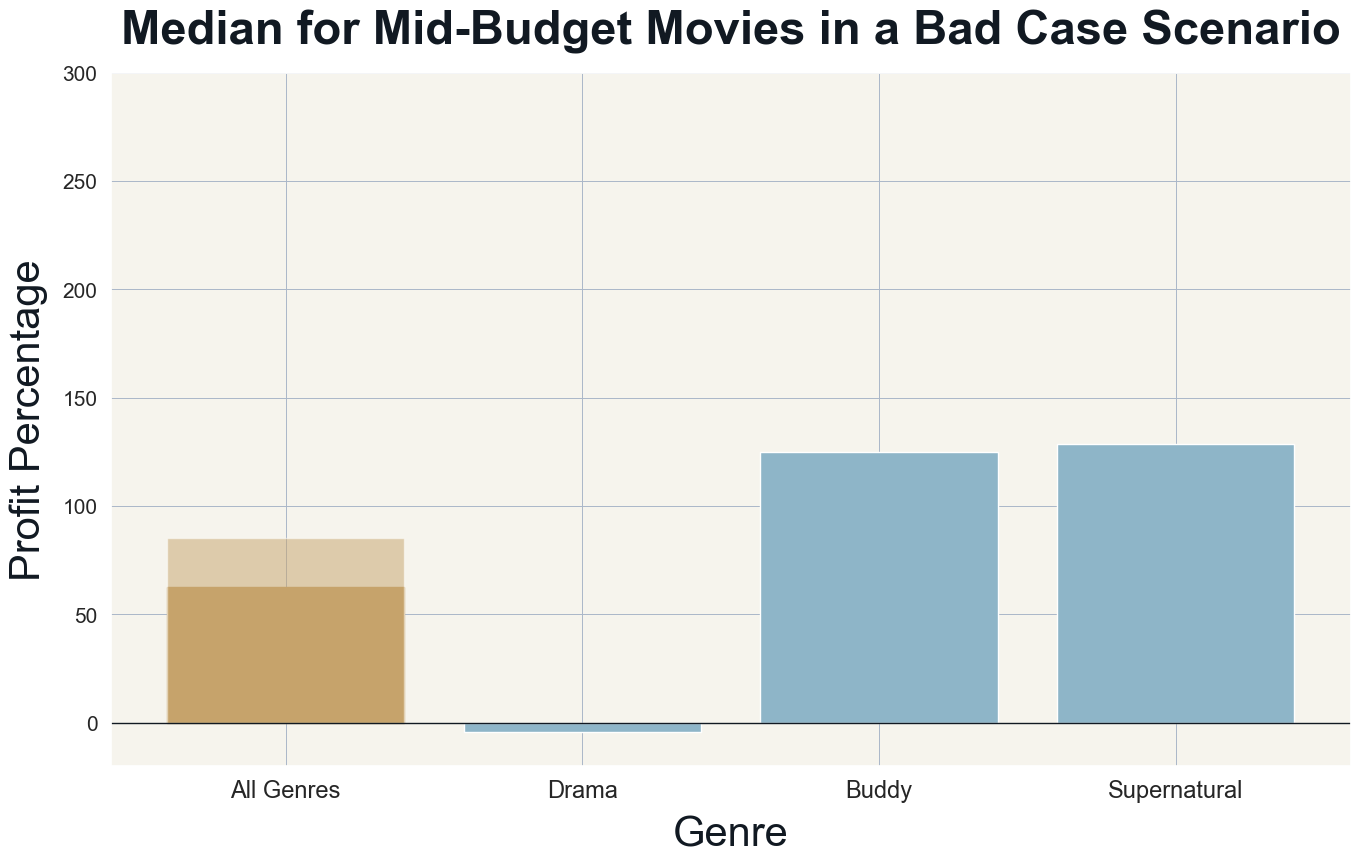

In [44]:
fig, ax = plt.subplots(figsize=(16,9))

# I drop comedy since there's no enough statistical evidence
# Comedy is the first if mid_genres_trust
data2 = mid_conf_df.loc[['Profit perc'] + mid_genres_trust[1:]]

ax.bar(data2.index, data2['Low band'], color='steelblue')

# The confidence interval on Profit %
ax.bar(x='Profit perc', height=mid_conf_df.loc['Profit perc','High band'],
       bottom=0, alpha=0.5,color='#C6A36B')
ax.get_children()[0].set_color('#C6A36B')

ax.set_xticklabels(('All Genres','Drama', 'Buddy', 'Supernatural'))

plt.yticks(fontsize=15)
plt.xticks(fontsize=17)

ax.set_ylabel('Profit Percentage', fontsize=30, labelpad=10, color='#111922')
ax.set_xlabel('Genre', fontsize=30, labelpad=10, color='#111922')
ax.set_title('Median for Mid-Budget Movies in a Bad Case Scenario',
             fontsize=34, pad=21, fontweight='bold', color='#111922')

plt.axhline(y=0, color='#111922',linewidth=1)

ax.set_ylim(-20,300)
ax.set_facecolor("#F1F1F1")
plt.grid(color = '#AAB7C8', linestyle = '-', linewidth = 0.7)
plt.show()

C:\Users\matte\AppData\Local\Temp\ipykernel_12832\789493097.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(('All Genres','Drama', 'Buddy', 'Supernatural'))


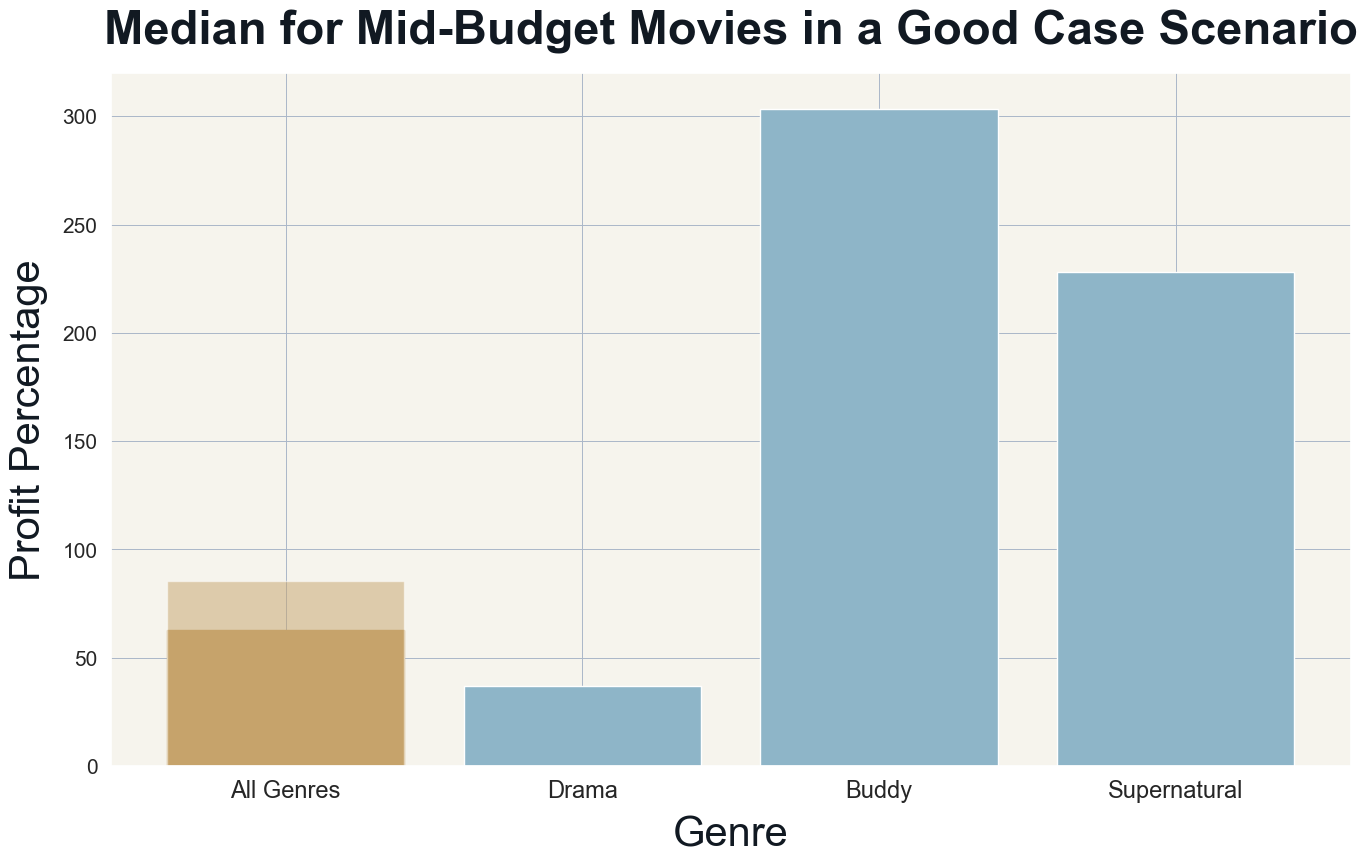

In [45]:
fig, ax = plt.subplots(figsize=(16,9))

# I drop comedy since there's no enough statistical evidence
# Comedy is the first if mid_genres_trust
data2 = mid_conf_df.loc[['Profit perc'] + mid_genres_trust[1:]]

# I change this so the bar of Profit % is equal to the one of the graph above
data2.loc['Profit perc','High band'] = data2.loc['Profit perc','Low band']

ax.bar(data2.index, data2['High band'], color='steelblue')

# The confidence interval on Profit %
ax.bar(x='Profit perc', height=mid_conf_df.loc['Profit perc','High band'],
       bottom=0, alpha=0.5,color='#C6A36B')
ax.get_children()[0].set_color('#C6A36B')

ax.set_xticklabels(('All Genres','Drama', 'Buddy', 'Supernatural'))
plt.yticks(fontsize=15)
plt.xticks(fontsize=17)

ax.set_ylabel('Profit Percentage', fontsize=30, labelpad=10, color='#111922')
ax.set_xlabel('Genre', fontsize=30, labelpad=10, color='#111922')
ax.set_title('Median for Mid-Budget Movies in a Good Case Scenario',
             fontsize=34, pad=21, fontweight='bold', color='#111922')

ax.set_ylim(0,320)

ax.set_facecolor("#F1F1F1")
plt.grid(color = '#AAB7C8', linestyle = '-', linewidth = 0.7)
plt.show()

In [46]:
mid_q3_conf = get_conf_df(mid_df_profit_perc, mid_genres_trust + ['Profit perc'], my_q3)

In [47]:
mid_q3_conf_df = pd.DataFrame(index=mid_q3_conf[0], data={'Low band':mid_q3_conf[1],
            'High band':mid_q3_conf[2]})

mask1 = mid_q3_conf_df.loc[:,'Low band'] > mid_q3_conf_df.loc['Profit perc', 'High band']
mask2 = mid_q3_conf_df.loc[:,'High band'] < mid_q3_conf_df.loc['Profit perc', 'Low band']

mid_q3_conf_df[(mask1 | mask2)]

,Low band,High band
drama,90.3333,162.6416
buddy,251.9359,423.6146
supernatural,203.4773,421.7391


#### In this case, the q3 for comedy genre does overlap the q3 for all the genres. So we can't say that the comedy does influece the profit %

In [48]:
mid_genres_trust

['comedy', 'drama', 'buddy', 'supernatural']

## High-Budget

#### Handling the outliers

In [49]:
get_limits(df.loc[budget_group == 'high', 'Profit perc'])

llimit -286.558825
ulimit 680.735295
Extreme llimit -649.29412
Extreme ulimit 1043.47059


In [50]:
(df.loc[budget_group == 'high', 'Profit perc'] > 680).sum()

12

In [51]:
high_df = df.loc[(budget_group == 'high') & (df['Profit perc'] < 680)]
high_df.shape

(349, 33)

#### Grab the genres with at least 15 occurrences

In [52]:
high_genres = high_df[genres].sum(axis=0).loc[high_df[genres].sum(axis=0) > 15].index.tolist()
print(high_genres)

['action', 'adventure', 'animated', 'comedy', 'epic', 'fantasy', 'fiction', 'science', 'superhero']


In [53]:
high_df_profit_perc = high_df[high_genres+ ['Profit perc']].apply(profit_genre, genres=high_genres,
                                     col='Profit perc', axis=1)

high_df_profit_perc[high_df_profit_perc == 0] = np.nan

#### ANOVA Test

In [66]:
from scipy.stats import f_oneway

high_data_for_anova = [high_df_profit_perc[x].dropna() for x in high_genres]

f_oneway(*high_data_for_anova)

F_onewayResult(statistic=2.5787107157642506, pvalue=0.009050940221140676)

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


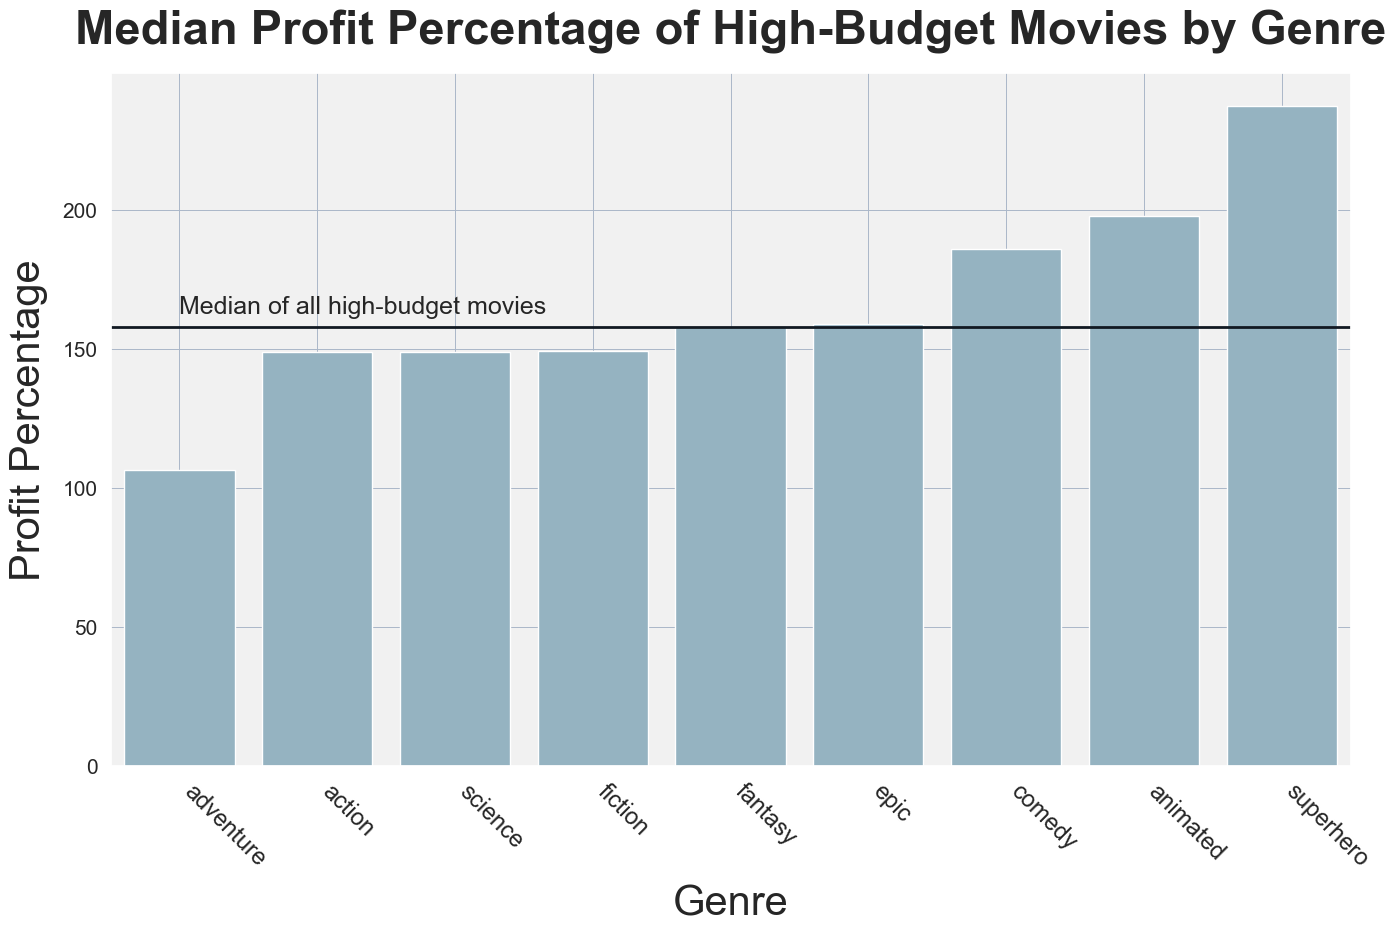

In [67]:
fig, ax = plt.subplots(figsize=(16,9))

data2 = high_df_profit_perc.drop(columns='Profit perc').median(axis=0).sort_values().to_frame().reset_index()

ax = sns.barplot(data=data2, x='index', y=0, color='steelblue', alpha=1)

plt.axhline(y=data2[0].median(), color='#111922',linewidth=2)
ax.annotate('Median of all high-budget movies', xy=(0, data2[0].median() + 7),
            ha='left', va='center', fontsize=18)

plt.yticks(fontsize=15)
plt.xticks(rotation=-45, fontsize=17, ha='left')

ax.set_ylabel('Profit Percentage', fontsize=30, labelpad=10)
ax.set_xlabel('Genre', fontsize=30, labelpad=10)
ax.set_title('Median Profit Percentage of High-Budget Movies by Genre',
             fontsize=34, pad=21, fontweight='bold')

ax.set_facecolor("#F1F1F1")
plt.grid(color = '#AAB7C8', linestyle = '-', linewidth = 0.7)
plt.show()

#### P-value and correlation

In [55]:
high_pearsonr_df_stat= []
high_pearsonr_df_pv= []
high_pearsonr_id = []

for genre in high_genres:
    values = pearsonr(high_df[genre], high_df['Profit perc'])
    high_pearsonr_df_stat.append(values[0])
    high_pearsonr_df_pv.append(values[1])
    high_pearsonr_id.append(genre)


high_pearsonr_df = pd.DataFrame(index=high_pearsonr_id, data={'Correlation coef.':high_pearsonr_df_stat,
            'P-value':high_pearsonr_df_pv}).sort_values('P-value')
high_pearsonr_df

,Correlation coef.,P-value
superhero,0.1836,0.0006
action,-0.1084,0.0429
adventure,-0.0784,0.1436
science,-0.0761,0.1561
fiction,-0.0683,0.2031
animated,0.0675,0.2085
fantasy,-0.0494,0.3575
epic,-0.0198,0.7124
comedy,0.0086,0.8724


In [56]:
high_pearsonr_df[high_pearsonr_df['P-value'] < 0.05]

,Correlation coef.,P-value
superhero,0.1836,0.0006
action,-0.1084,0.0429


In [57]:
high_genres_trust = high_pearsonr_df[high_pearsonr_df['P-value'] < 0.05].index.tolist()

#### Confidence interval

In [58]:
high_mean_conf = get_conf_df(high_df_profit_perc,['Profit perc'] +high_genres_trust, np.median)

high_conf_df = pd.DataFrame(index=high_mean_conf[0], data={'Low band':high_mean_conf[1],
            'High band':high_mean_conf[2]})
high_conf_df

,Low band,High band
Profit perc,148.7826,194.4079
superhero,198.7649,281.8667
action,114.6343,188.8106


In [59]:
mask1 = high_conf_df.loc[:,'Low band'] > high_conf_df.loc['Profit perc', 'High band']
mask2 = high_conf_df.loc[:,'High band'] < high_conf_df.loc['Profit perc', 'Low band']

high_genres_trust = high_conf_df[(mask1 | mask2)].index.tolist()
high_conf_df[(mask1 | mask2)]

,Low band,High band
superhero,198.7649,281.8667


C:\Users\matte\AppData\Local\Temp\ipykernel_12832\2045021654.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(('All Genres','Superhero', 'Action'))


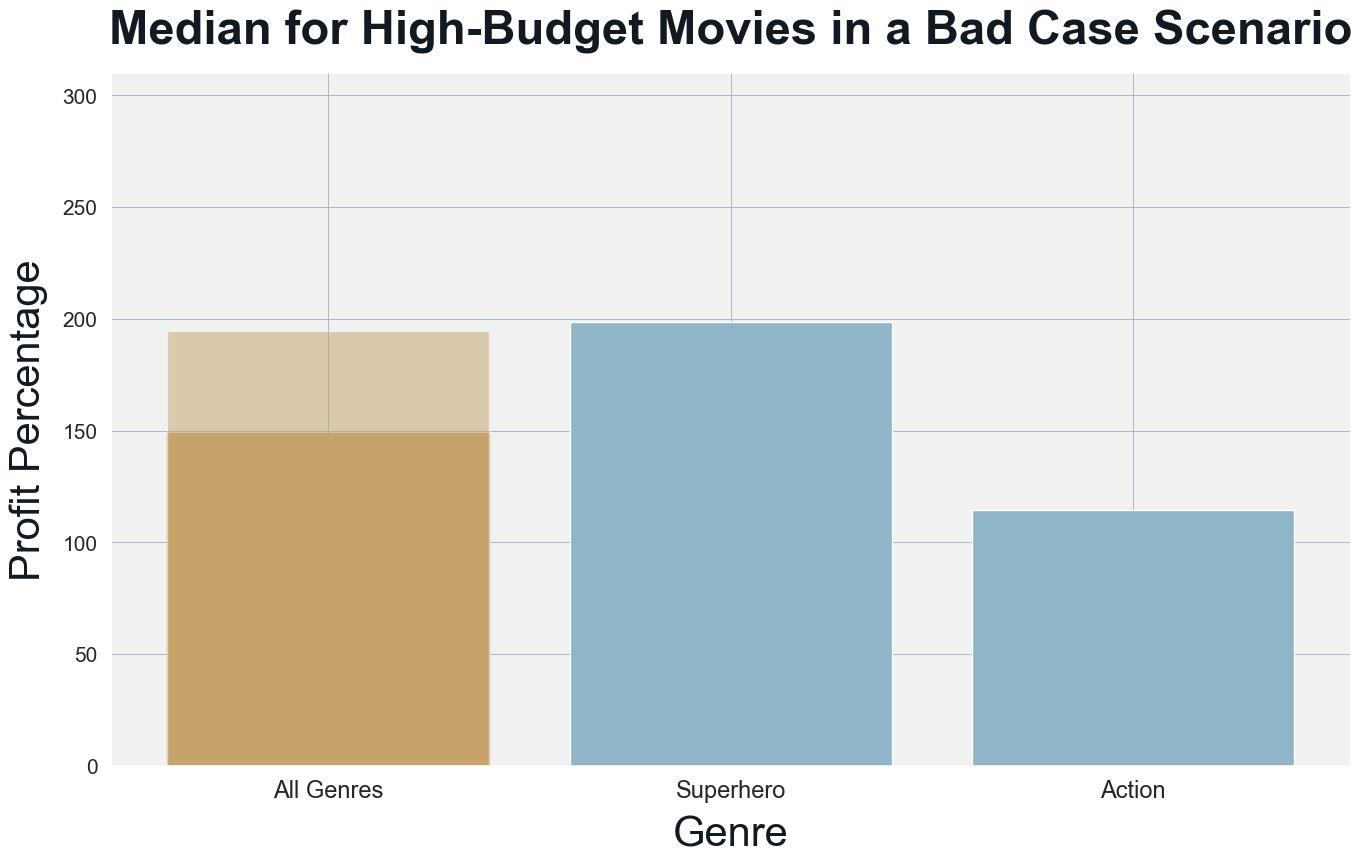

In [68]:
fig, ax = plt.subplots(figsize=(16,9))

data2 = high_conf_df

ax.bar(data2.index, data2['Low band'], color='steelblue')

# The confidence interval on Profit %
ax.bar(x='Profit perc', height=high_conf_df.loc['Profit perc','High band'],
       bottom=0, alpha=0.5,color='#C6A36B')
ax.get_children()[0].set_color('#C6A36B')

ax.set_xticklabels(('All Genres','Superhero', 'Action'))

plt.yticks(fontsize=15)
plt.xticks(fontsize=17)

ax.set_ylabel('Profit Percentage', fontsize=30, labelpad=10, color='#111922')
ax.set_xlabel('Genre', fontsize=30, labelpad=10, color='#111922')
ax.set_title('Median for High-Budget Movies in a Bad Case Scenario',
             fontsize=34, pad=21, fontweight='bold', color='#111922')

plt.axhline(y=0, color='#111922',linewidth=1)

ax.set_ylim(0,310)
ax.set_facecolor("#F1F1F1")
plt.grid(color = '#AAB7C8', linestyle = '-', linewidth = 0.7)
plt.show()

C:\Users\matte\AppData\Local\Temp\ipykernel_12832\1813379242.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(('All Genres','Superhero', 'Action'))


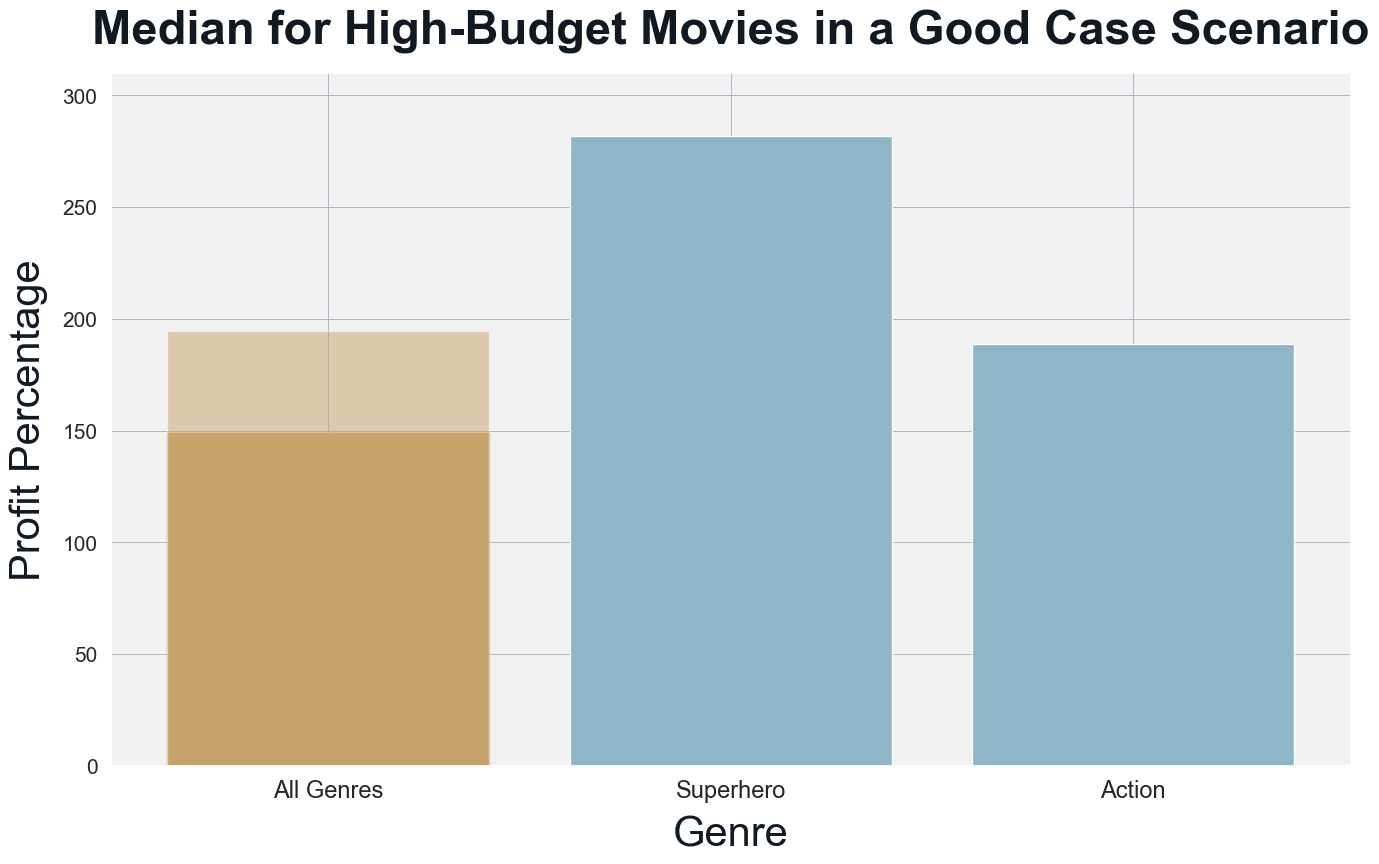

In [69]:
fig, ax = plt.subplots(figsize=(16,9))


data2 = high_conf_df.copy()

# I change this so the bar of Profit % is equal to the one of the graph above
data2.loc['Profit perc','High band'] = data2.loc['Profit perc','Low band']

ax.bar(data2.index, data2['High band'], color='steelblue')

# The confidence interval on Profit %
ax.bar(x='Profit perc', height=high_conf_df.loc['Profit perc','High band'],
       bottom=0, alpha=0.5,color='#C6A36B')
ax.get_children()[0].set_color('#C6A36B')

ax.set_xticklabels(('All Genres','Superhero', 'Action'))
plt.yticks(fontsize=15)
plt.xticks(fontsize=17)

ax.set_ylabel('Profit Percentage', fontsize=30, labelpad=10, color='#111922')
ax.set_xlabel('Genre', fontsize=30, labelpad=10, color='#111922')
ax.set_title('Median for High-Budget Movies in a Good Case Scenario',
             fontsize=34, pad=21, fontweight='bold', color='#111922')

ax.set_ylim(0,310)

ax.set_facecolor("#F1F1F1")
plt.grid(color = '#AAB7C8', linestyle = '-', linewidth = 0.7)
plt.show()

In [62]:
high_q3_conf = get_conf_df(high_df_profit_perc, high_genres_trust + ['Profit perc'], my_q3)

In [63]:
high_q3_conf_df = pd.DataFrame(index=high_q3_conf[0], data={'Low band':high_q3_conf[1],
            'High band':high_q3_conf[2]})

mask1 = high_q3_conf_df.loc[:,'Low band'] > high_q3_conf_df.loc['Profit perc', 'High band']
mask2 = high_q3_conf_df.loc[:,'High band'] < high_q3_conf_df.loc['Profit perc', 'Low band']

high_q3_conf_df[(mask1 | mask2)]

,Low band,High band


In [64]:
high_q3_conf_df

,Low band,High band
superhero,296.8945,452.9350
Profit perc,281.1703,327.4054


### In the high-budget movies there's no statistical evidece that the genre influeces the provit % of that movie.